# XGBoost hyperparameter grid search: OPERA study example

The goal of this notebook is to provide a quick demonstration of XGBoost in conjunction with "traditional" sklearn processes and hyperparameter tuning using grid search. Grid search systematically evaluates predefined combinations of model hyperparameters to identify the settings that yield the best predictive performance.

This dataset is obtained from the Optimizing Patient Experience and Response to Topical Analgesics (OPERA) study. It consists in 631 patients with 50 survey questions. The objective is to investigate the effect of replacing opioid therapies with topical analgesics on patients with chronic pain and record the changes in multiple aspects of their life such as pain and medicine reduction, interference with everyday activities, and reduction of complaints. [Gudin JA, Brennan MJ, Harris ED et al.  Changes in pain and concurrent pain medication use following compounded topical analgesic treatment for chronic pain: 3- and 6-month follow-up results from the prospective, observational optimizing patient experience and response to topical analgesics study. J Pain Res 2017;10:2341–54.](https://www.tandfonline.com/doi/full/10.2147/JPR.S143513). You can also see a state of the art utilization of this dataset in *MEvA-X: a hybrid multiobjective evolutionary tool using an XGBoost classifier for biomarkers discovery on biomedical datasets* (https://doi.org/10.1093/bioinformatics/btad384 and https://github.com/PanKonstantinos/MEvA-X).


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
import xgboost as xgb

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV


In [3]:
df = pd.read_csv("../data/OPERA.csv", index_col=[0,1])
df.index = df.index.droplevel(level=0)

df = df.transpose()
df.head()

Feature,Age,Gender,Least_24h,Average_pain,Current_pain,Overall_Pain_interference,Int_Gen_Activity,Int_Mood,Int_Walking_ability,Int_Work,...,Severity_Score,Tot_Compl_categ,TFFC1,TFFC2,TFFC3,TFFC4,BPISeverityChange,BPIInterferenceChange,ChangeGrandTotalMedicines,ChangeInTotalComplaintsNotIncludingOther
SM.1,0.396040,1.0,0.0,0.2,0.0,1.0,0.1,0.2,0.0,0.1,...,0.225,0.25,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
SM.2,0.930733,1.0,0.7,0.7,1.0,0.7,0.9,0.7,0.9,0.9,...,0.850,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM.3,0.517688,1.0,0.3,0.4,0.4,0.8,0.4,0.4,0.2,0.5,...,0.525,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SM.4,0.606992,0.0,0.4,0.2,0.5,0.8,0.2,0.2,0.0,0.1,...,0.475,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM.5,0.801118,0.0,0.1,0.2,0.0,0.0,0.5,0.5,0.5,0.5,...,0.175,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


This dataset has already been preprocessed with a KNN imputation and a min-max scaling normalizing each feature to the [0,1] range.


The dataset contains 50 features and 4 targets.

Here is a brief description:

Base demographics:
 * Age
 * Gender
 
Brief Pain Index ([example of form](https://www.npcrc.org/files/news/briefpain_short.pdf)):
 * Pain_other : 0/1 for presence of pain other than "usual" minor pains of daily life
 * Worst_24h
 * Least_24h
 * Average_pain
 * Current_pain
 * Severity_Score
 * Overall_Pain_interference
 * Avg_Interference
 * Int_Gen_Activity
 * Int_Mood
 * Int_Walking_ability
 * Int_Work
 * Int_Relationship
 * Int_Sleep
 * Int_Life_enjoyment
 
Complaint about different types of pain sources (*_bin*: 0/1 for presence of complaint ; *_categ* or *_cat*: number of complaints) :
 * Arthritis
 * NeuroRadic : neuropathy or radiculopathy pain
 * MyoMuscul :  myofascial or musculoskeletal pain
 * Tendinitis
 * Other
 * Pain_categ : number of pain categories with complaints
 * Tot_Compl_categ : same as above, but without other
 * Grand_Tot_Compl : total number of complaints (except other)

Which formulation of a topical pain medication was given to the patient (this can be considered the intervention of the study):
 * TFFC1
 * TFFC2
 * TFFC3
 * TFFC4

Additional Medication taken:
 * Meds_3days : 0/1 for medication taken in the last 3 days
 * Categ_of_meds : number of medication categories taken in the last 3 days
 * OTC : Over The Counter medications
 * AntiInflam : aintiinflammatory meds (also includes a total weight taken column)
 * Opioids_No_Anticonvulsants
 * Narcotic (also includes a total weight taken column)
 * Opioid_comb and Opioid_others : counts of different subsets of opioids 
 * Not_on_Anticonvulsant : 0/1 presence of anticonvulsant
 * Grand_Tot_Med : total number of medication taken


Finally, the different targets in this dataset are measured improvement between the baseline and the follow-up time:
 * BPISeverityChange : change in pain severity
 * BPIInterferenceChange : change in pain interference
 * ChangeGrandTotalMedicines : change in total medicine taken
 * ChangeInTotalComplaintsNotIncludingOther : change in number of complaints


In [4]:
targets = ['BPISeverityChange','BPIInterferenceChange', 
           'ChangeGrandTotalMedicines','ChangeInTotalComplaintsNotIncludingOther']

In [5]:
X = df.drop(columns=targets)
Y = df[targets]

## EDA

***
BPISeverityChange
0.0    506
1.0    125
Name: count, dtype: int64
***
BPIInterferenceChange
0.0    523
1.0    108
Name: count, dtype: int64
***
ChangeGrandTotalMedicines
0.0    581
1.0     50
Name: count, dtype: int64
***
ChangeInTotalComplaintsNotIncludingOther
0.0    481
1.0    150
Name: count, dtype: int64


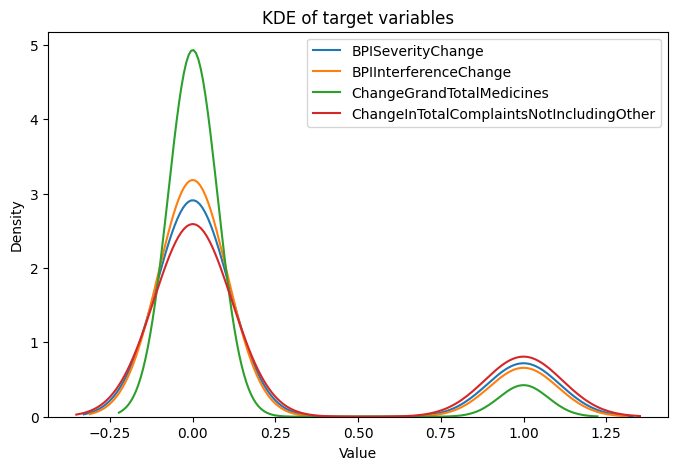

In [ ]:
plt.figure(figsize=(8,5))

for c in Y.columns:
    sns.kdeplot(Y[c], label=c)
    print("***")
    print(Y[c].value_counts())

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("KDE of target variables")
plt.legend()     # <-- adds legend
plt.show()

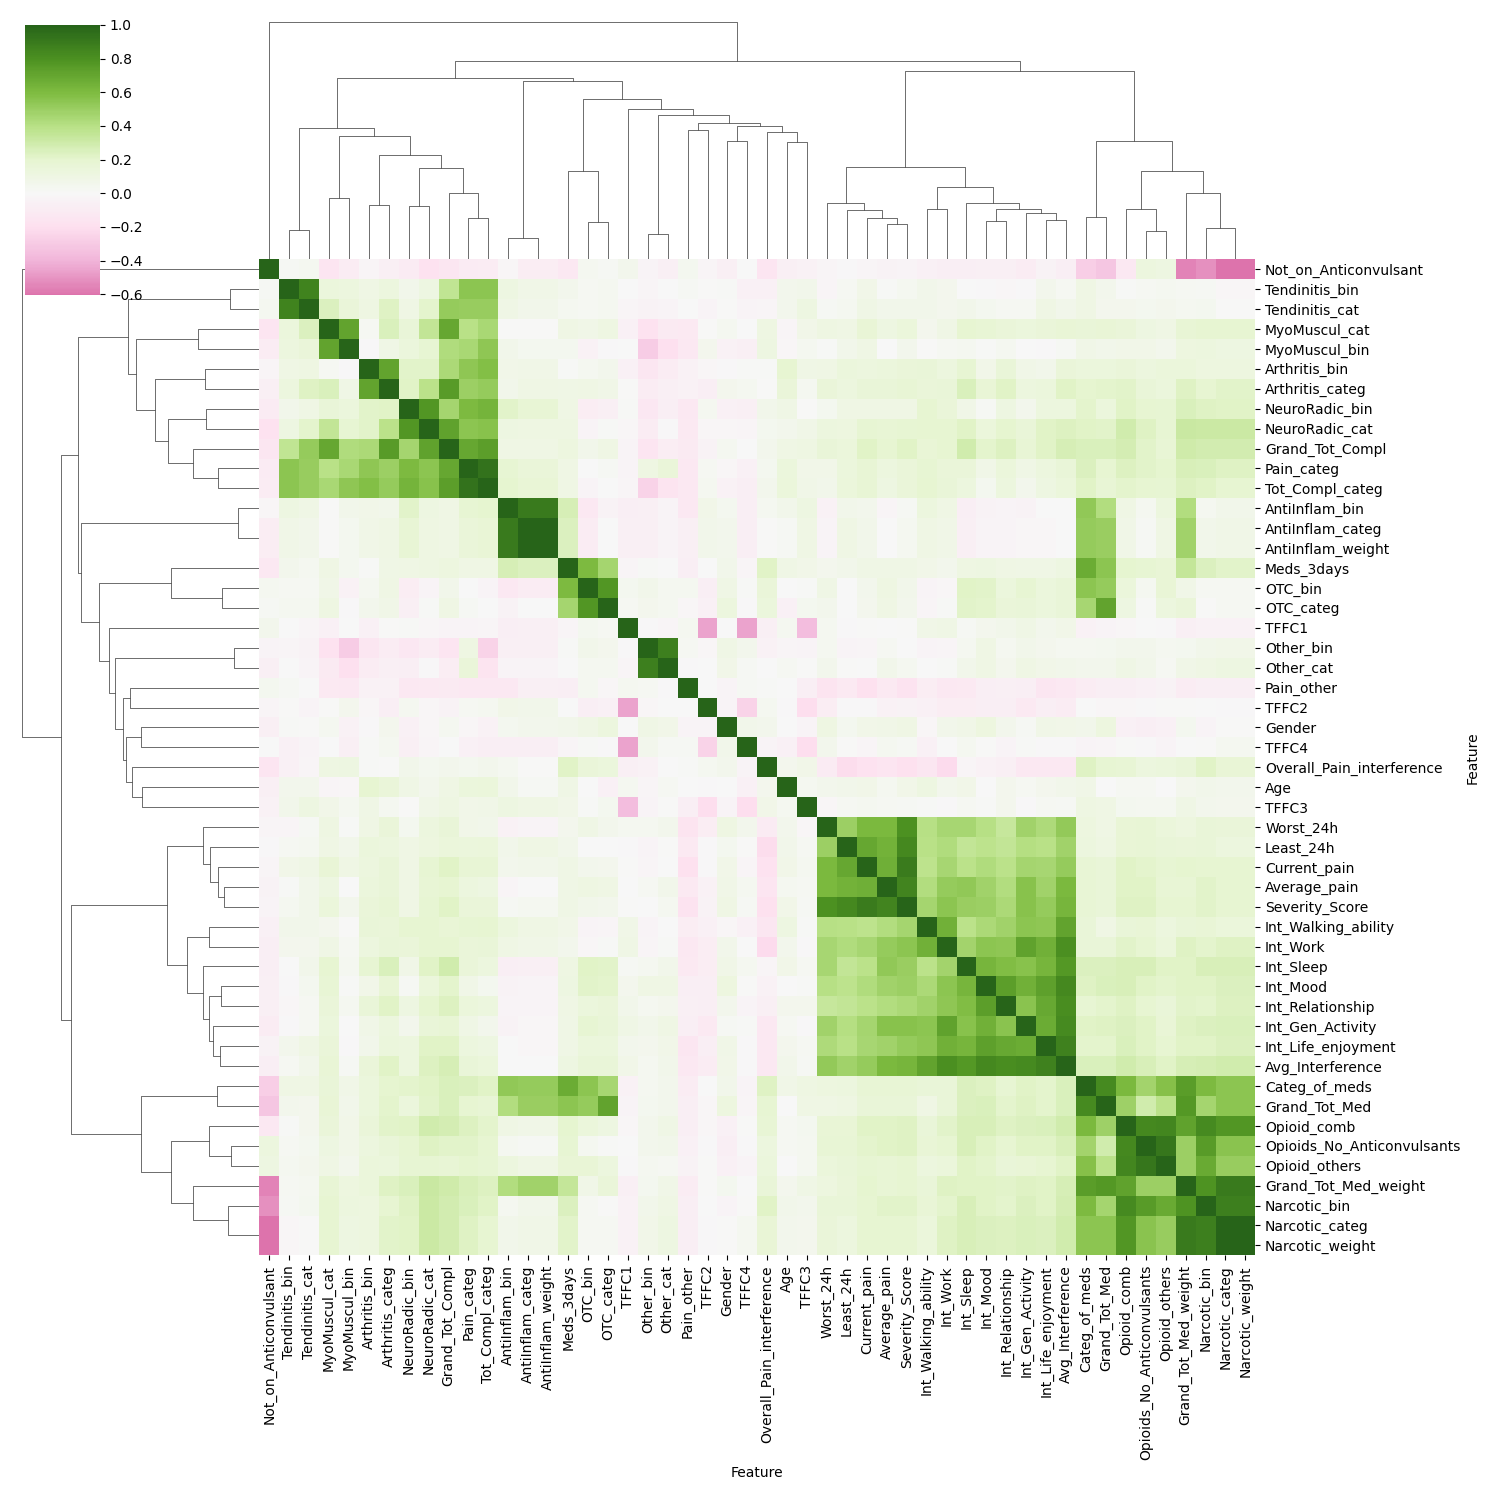

In [7]:
sns.clustermap( X.corr() ,
              figsize=(15, 15),
              cmap = "PiYG" , center = 0)

As we can see, a few columns are highly correlated (>0.9).

Text(0, 0.5, 'explained variance ratio')

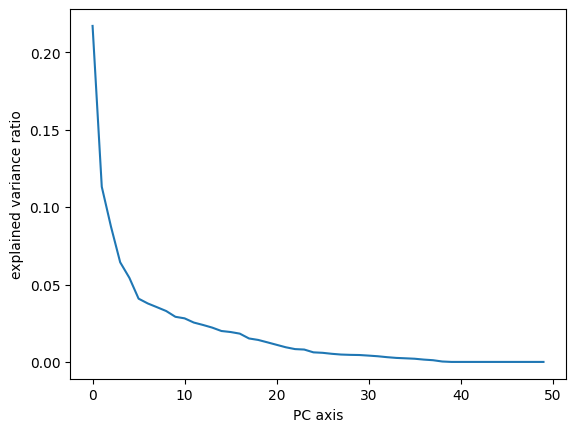

In [ ]:
sc = StandardScaler()
pca = PCA()

x_pca = pca.fit_transform( sc.fit_transform(X) )


plt.plot( pca.explained_variance_ratio_ )
plt.xlabel("PC axis")
plt.ylabel("explained variance ratio")

<Axes: >

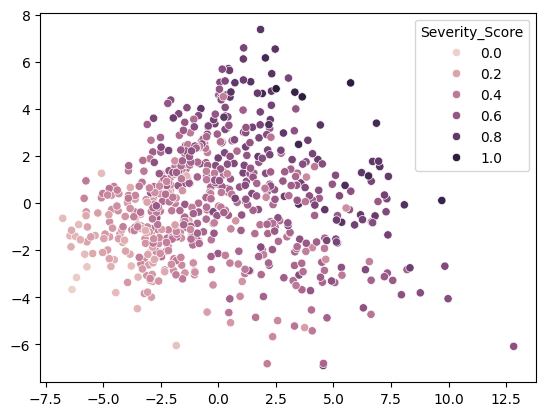

In [55]:
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1] , hue = X.Severity_Score)

Choose one of the target and train a classifier to predict it. Try to see if you can gain some insight on the data by interpreting your model.

<Axes: xlabel='BPISeverityChange', ylabel='Count'>

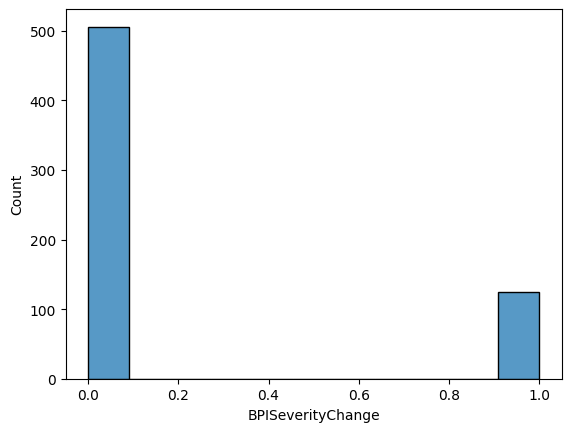

In [10]:
# Dsitribution of my potential target
sns.histplot(df['BPISeverityChange'])

In [22]:
y = df['BPISeverityChange']
X = df.drop(columns=targets)

In [23]:
# Deal with features that are highly correlated (forms clusters on the correlation heatmap)
# Pick 1–2 representative features per correlated block

import numpy as np
import pandas as pd

def remove_correlated_features(X, y, corr_threshold=0.8):
    """
    Iteratively remove features that are too correlated with each other.
    Between each correlated pair, we drop the one less correlated with y.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (no target column).
    y : pd.Series or 1D array
        Target variable.
    corr_threshold : float
        Absolute correlation threshold above which we consider features "too correlated".
    
    Returns
    -------
    kept_columns : list
        List of feature names kept.
    dropped_columns : list
        List of dropped feature names.
    """
    X_corr = X.corr().abs().copy()
    
    # Correlation of each feature with the target (for deciding which to keep)
    corr_with_y = X.apply(lambda col: col.corr(y)).abs()
    
    # We’ll work on a copy of the column names
    cols = list(X_corr.columns)
    dropped = []

    # Set diagonal to 0 so we don’t pick self-correlation
    np.fill_diagonal(X_corr.values, 0.0)
    
    while True:
        # Find the pair with maximum correlation
        max_corr = X_corr.values.max()
        if max_corr < corr_threshold:
            break  # we're done
        
        # indices of the max correlation
        i, j = np.where(X_corr.values == max_corr)
        i, j = i[0], j[0]
        
        col_i = cols[i]
        col_j = cols[j]
        
        # Decide which one to drop: keep the one more correlated with y
        if corr_with_y[col_i] < corr_with_y[col_j]:
            col_to_drop = col_i
        else:
            col_to_drop = col_j
        
        dropped.append(col_to_drop)
        
        # Remove from correlation matrix & lists
        drop_idx = cols.index(col_to_drop)
        cols.pop(drop_idx)
        X_corr = X_corr.drop(index=col_to_drop, columns=col_to_drop)
        
        # also drop from corr_with_y
        corr_with_y = corr_with_y.drop(col_to_drop)
        
        # reset diagonal to 0 after shape changed
        np.fill_diagonal(X_corr.values, 0.0)
    
    kept = cols
    return kept, dropped

kept_cols, dropped_cols = remove_correlated_features(X, y, corr_threshold=0.8)

print("Kept:", kept_cols)
print("Dropped:", dropped_cols)

X_reduced = X[kept_cols]

Kept: ['Age', 'Gender', 'Overall_Pain_interference', 'Int_Gen_Activity', 'Int_Mood', 'Int_Walking_ability', 'Int_Work', 'Int_Relationship', 'Int_Sleep', 'Arthritis_bin', 'Arthritis_categ', 'Int_Life_enjoyment', 'Meds_3days', 'Categ_of_meds', 'OTC_bin', 'OTC_categ', 'AntiInflam_categ', 'Narcotic_categ', 'NeuroRadic_bin', 'NeuroRadic_cat', 'MyoMuscul_cat', 'MyoMuscul_bin', 'Tendinitis_cat', 'Other_cat', 'Pain_other', 'Worst_24h', 'Grand_Tot_Compl', 'Not_on_Anticonvulsant', 'Pain_categ', 'Opioid_comb', 'Severity_Score', 'TFFC1', 'TFFC2', 'TFFC3', 'TFFC4']
Dropped: ['AntiInflam_weight', 'Narcotic_weight', 'Tot_Compl_categ', 'Opioid_others', 'Grand_Tot_Med_weight', 'AntiInflam_bin', 'Current_pain', 'Narcotic_bin', 'Other_bin', 'Avg_Interference', 'Tendinitis_bin', 'Average_pain', 'Least_24h', 'Opioids_No_Anticonvulsants', 'Grand_Tot_Med']


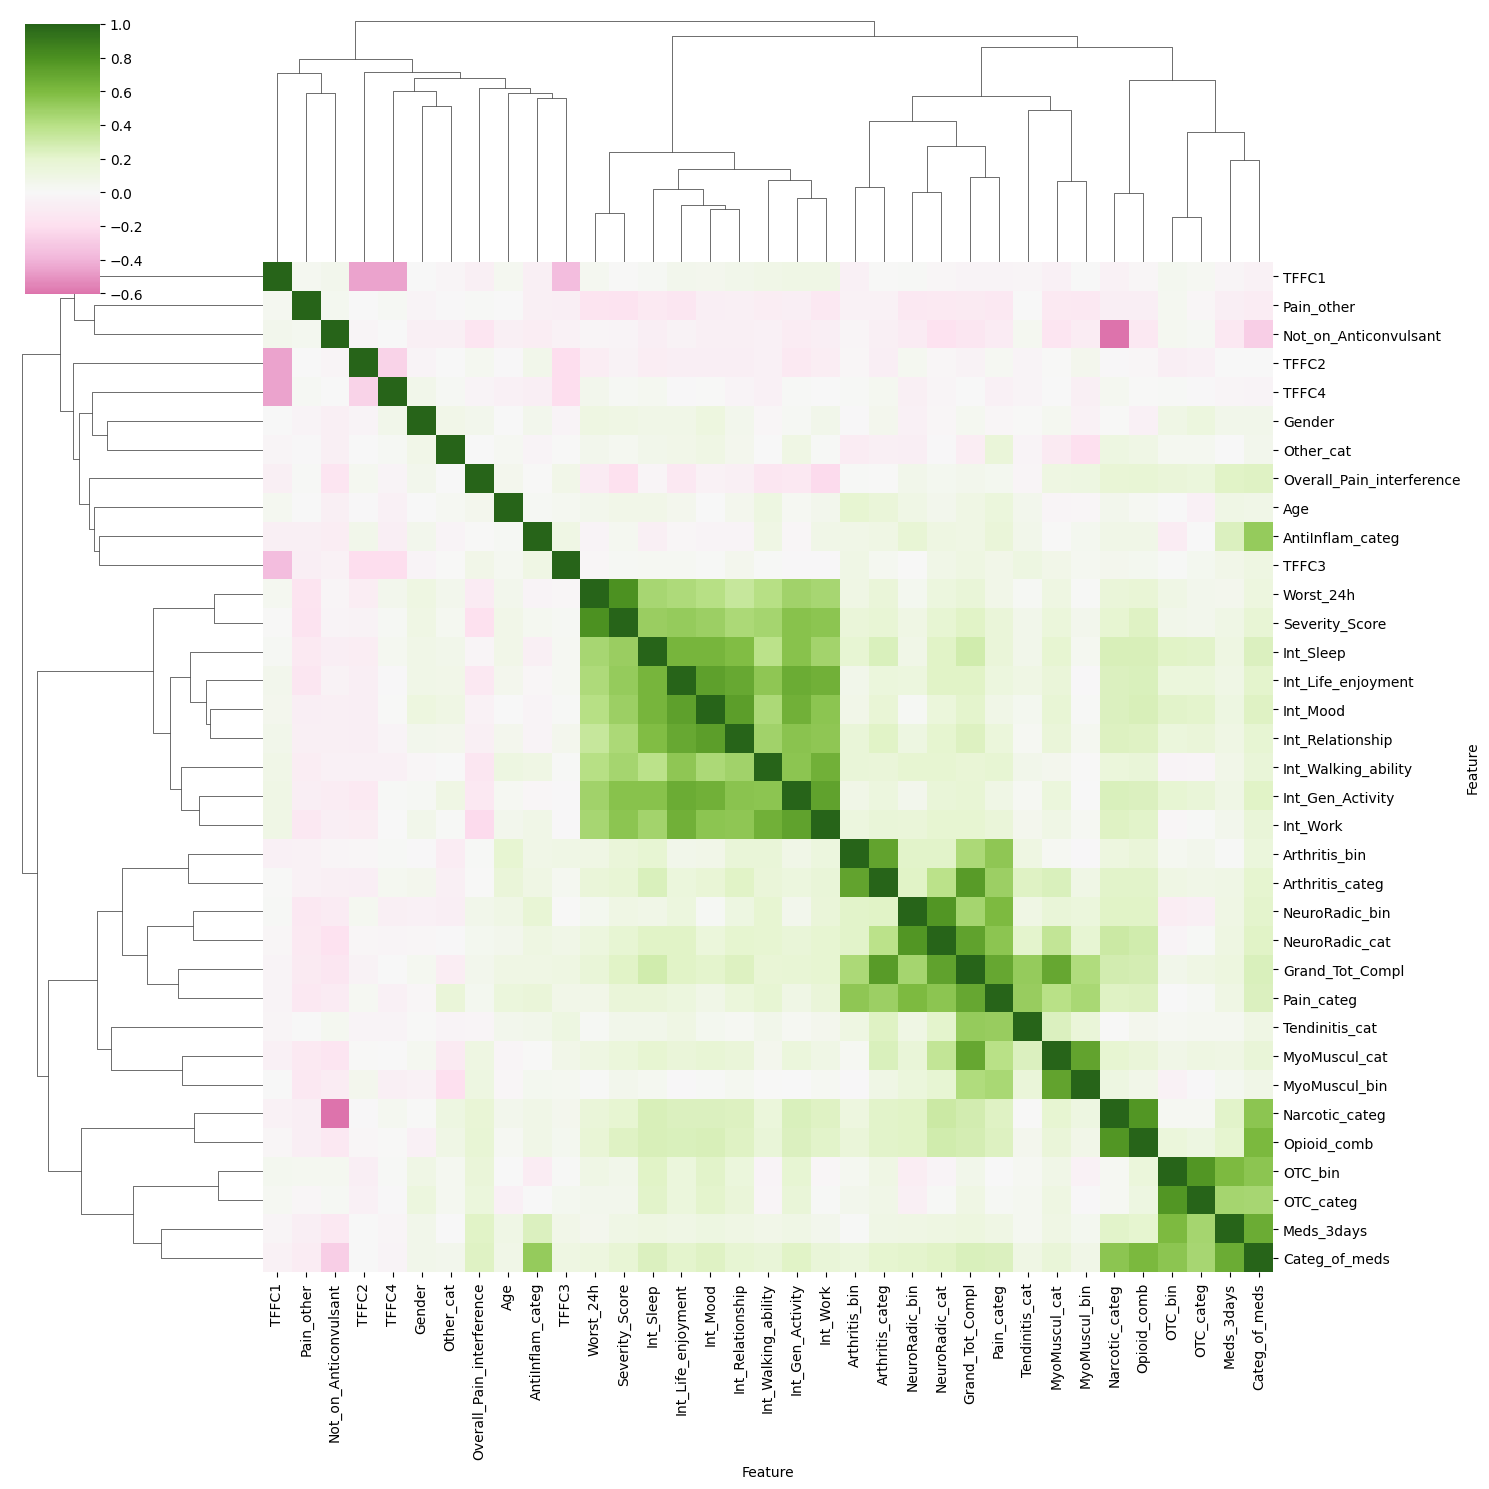

In [ ]:
sns.clustermap(X_reduced.corr() ,
              figsize=(15, 15),
              cmap = "PiYG" , center = 0)

In [ ]:
Xt, Xv, yt, yv = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

print(f"train set length: {len(yt)}")
print(f"valid set length: {len(yv)}")

train set length: 504
valid set length: 127


In [30]:
print(yt)

SM.7      0.0
SM.105    1.0
SM.115    0.0
SM.551    0.0
SM.397    0.0
         ... 
SM.72     0.0
SM.107    0.0
SM.271    0.0
SM.436    1.0
SM.103    0.0
Name: BPISeverityChange, Length: 504, dtype: float64


This is a classic case of class imbalance:

In [27]:
# XGBoost regressor
import multiprocessing
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)
xgb_model.fit( Xt, yt)
pd.crosstab( yv, xgb_model.predict(Xv) ,  rownames=['true'], colnames=['predicted'] )

predicted,0,1
true,,
0.0,92,5
1.0,20,10


In [35]:
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    scale_pos_weight=ratio
)
xgb_model.fit( Xt, yt)
pd.crosstab( yv, xgb_model.predict(Xv) ,  rownames=['true'], colnames=['predicted'] )

predicted,0,1
true,,
0.0,90,7
1.0,19,11


It still doesnt look great when it comes to false positives and false negatives.

1. Tune the probability threshold instead of using 0.5:

In [37]:
y_proba = xgb_model.predict_proba(Xv)[:, 1]
# try thresholds like 0.4, 0.35, etc.
y_pred_040 = (y_proba > 0.4).astype(int)

from sklearn.metrics import confusion_matrix

def show_cm_for_threshold(threshold):
    y_pred = (y_proba > threshold).astype(int)
    cm = confusion_matrix(yv, y_pred)
    print(f"\nThreshold = {threshold}")
    print(cm)

for thr in [0.5, 0.45, 0.4, 0.35, 0.3]:
    show_cm_for_threshold(thr)



Threshold = 0.5
[[90  7]
 [19 11]]

Threshold = 0.45
[[90  7]
 [19 11]]

Threshold = 0.4
[[87 10]
 [19 11]]

Threshold = 0.35
[[87 10]
 [19 11]]

Threshold = 0.3
[[82 15]
 [18 12]]


In [38]:
from sklearn.metrics import f1_score
import numpy as np

thresholds = np.linspace(0.1, 0.9, 50)
scores = []

for t in thresholds:
    y_pred = (y_proba > t).astype(int)
    scores.append(f1_score(yv, y_pred))

best_threshold = thresholds[np.argmax(scores)]
best_threshold


np.float64(0.573469387755102)

This model is heavily biased toward predicting 0. Even with lower thresholds, it barely predicts more 1s. This means:

- The predicted probabilities are clustered near 0
- Responders do not form a clear separate cluster in feature space
- Our features do not strongly separate responders from non-responders

That's why now I'll try to tune hyperparameters. I'll use eval_metric='auc' and XGBClassifier parameters:

- max_depth (how deep each decision tree can grow)
- min_child_weight (how much data you need in a leaf before splitting)
- subsample (fraction of rows (patients) used for each tree)
- colsample_bytree (fraction of features sampled for each tree)
- eta (hw fast XGBoost learns; equivalent to the learning rate in gradient boosting)

I'll try out a simple grid search (trying every possible combination) and next Hyperopt (search via tree-structured Parzen Estimator).

Hyperopt:

- Tries some random combinations.
- Learns which parameter regions give good scores.
- Focuses the search in promising areas.
- Avoids unpromising parts of the hyperparameter space.

It models hyperparameters with:

- l(x) = bad configurations
- g(x) = good configurations

# Grid search for hyperparameter tuning

In [ ]:
%%time

# Simple grid search

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

# Make sure the number of threads is balanced.
clf = GridSearchCV(
    xgb_model,
    {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200], 'eta' : [0.01,0.1,1.0]},
    scoring='roc_auc_ovr',
    verbose=1,
    n_jobs=1,
)
clf.fit(Xt, yt)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.6922455189464175
{'eta': 0.1, 'max_depth': 6, 'n_estimators': 50}
CPU times: user 24.1 s, sys: 135 ms, total: 24.3 s
Wall time: 4.16 s


Test different values of max_bin for XGBoost’s histogram-based tree method (tree_method="hist"). Performance improves as we go from 2 to 32 bins.

In [43]:
from sklearn.model_selection import cross_val_score
import numpy as np
from time import time

## recording training time and performance gain
## for different values of max_bin

time_list = []
scores = []
mb_list = []
labels = df.loc[Xt.index, 'BPISeverityChange'].astype(int)

for mb in [2,4,8,16,32,64,128,256,512,1024]:

    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count(),
        tree_method="hist",
        max_bin=mb,
        scale_pos_weight=ratio,     # <-- OPTIONAL: add class imbalance fix
        eval_metric='auc'
    )

    t1 = time()
    cv_score = cross_val_score(
        xgb_model,
        Xt,
        labels,
        cv=5,
        scoring='roc_auc'
    )
    time_list.append(time() - t1)
    scores.append(cv_score.mean())
    mb_list.append(mb)
    print(f"max_bin={mb} => CV AUC: {cv_score.mean():.4f} in {time_list[-1]:.2f} sec")

max_bin=2 => CV AUC: 0.6042 in 0.48 sec
max_bin=4 => CV AUC: 0.6537 in 0.52 sec
max_bin=8 => CV AUC: 0.6729 in 0.25 sec
max_bin=16 => CV AUC: 0.6778 in 0.23 sec
max_bin=32 => CV AUC: 0.6700 in 0.26 sec
max_bin=64 => CV AUC: 0.6525 in 0.29 sec
max_bin=128 => CV AUC: 0.6671 in 0.21 sec
max_bin=256 => CV AUC: 0.6908 in 0.27 sec
max_bin=512 => CV AUC: 0.6743 in 0.27 sec
max_bin=1024 => CV AUC: 0.6743 in 0.22 sec


In [44]:
xgb_model = xgb.XGBClassifier(
    tree_method="hist",
    max_bin=32,
    scale_pos_weight=ratio,
    eval_metric='auc',
    n_jobs=multiprocessing.cpu_count()-2,
)
xgb_model.fit( Xt, yt)
pd.crosstab( yv, xgb_model.predict(Xv) ,  rownames=['true'], colnames=['predicted'] )

predicted,0,1
true,,
0.0,90,7
1.0,18,12


It slightly improved recall for class 1 (from 0.37 → 0.40).

In [46]:
from sklearn.model_selection import cross_val_score
import numpy as np
from time import time

## recording training time and performance gain
## for different values of max_bin

time_list = []
scores = []
mb_list = []
for mb in [2,4,8,16,32,64,128,256,512,1024]:

    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count(),
        tree_method="hist" , max_bin = mb,
        scale_pos_weight=ratio
 )


    t1 = time()
    cv_score = cross_val_score(xgb_model , Xt,
        labels , cv = 5, scoring='roc_auc_ovr')
    time_list.append( time()-t1 )
    
    scores.append( cv_score.mean() )
    mb_list.append( mb )
    
    time_list.append(time() - t1)
    scores.append(cv_score.mean())
    mb_list.append(mb)
    print(f"max_bin={mb} => CV AUC: {cv_score.mean():.4f} in {time_list[-1]:.2f} sec")

max_bin=2 => CV AUC: 0.6042 in 0.47 sec
max_bin=4 => CV AUC: 0.6537 in 0.32 sec
max_bin=8 => CV AUC: 0.6729 in 0.28 sec
max_bin=16 => CV AUC: 0.6778 in 0.33 sec
max_bin=32 => CV AUC: 0.6700 in 0.28 sec
max_bin=64 => CV AUC: 0.6525 in 0.51 sec
max_bin=128 => CV AUC: 0.6671 in 0.25 sec
max_bin=256 => CV AUC: 0.6908 in 0.27 sec
max_bin=512 => CV AUC: 0.6743 in 0.67 sec
max_bin=1024 => CV AUC: 0.6743 in 0.44 sec


Based on this run, max_bin=256 gives the highest CV AUC.

In [47]:
xgb_model = xgb.XGBClassifier(
    tree_method="hist",
    max_bin=256,
    scale_pos_weight=ratio,
    n_estimators=50,        # from GridSearchCV
    max_depth=6,            # from GridSearchCV
    eta=0.1,                # from GridSearchCV
    eval_metric='auc',
    n_jobs=multiprocessing.cpu_count()-2
)
xgb_model.fit( Xt, yt)
pd.crosstab( yv, xgb_model.predict(Xv) ,  rownames=['true'], colnames=['predicted'] )

predicted,0,1
true,,
0.0,83,14
1.0,16,14


So, now we catch more responders (recall went up from ~0.37 → ~0.47).

In [48]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb_model.predict(Xv)
y_proba = xgb_model.predict_proba(Xv)[:, 1]

print(classification_report(yv, y_pred))
print("Val ROC AUC:", roc_auc_score(yv, y_proba))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85        97
         1.0       0.50      0.47      0.48        30

    accuracy                           0.76       127
   macro avg       0.67      0.66      0.66       127
weighted avg       0.76      0.76      0.76       127

Val ROC AUC: 0.756701030927835


The XGB object lets us use a validation set to monitor the model during the different iterations

In [49]:
xgb_model = xgb.XGBClassifier(tree_method="hist", 
                        eval_metric = "auc", n_estimators=10)

xgb_model.fit(Xt, yt, eval_set=[(Xt, yt),(Xv, yv)] )

xgb_model.evals_result_

[0]	validation_0-auc:0.85041	validation_1-auc:0.65533
[1]	validation_0-auc:0.91404	validation_1-auc:0.71426
[2]	validation_0-auc:0.95989	validation_1-auc:0.72715
[3]	validation_0-auc:0.97933	validation_1-auc:0.73213
[4]	validation_0-auc:0.98106	validation_1-auc:0.72182
[5]	validation_0-auc:0.98588	validation_1-auc:0.72612
[6]	validation_0-auc:0.99189	validation_1-auc:0.72852
[7]	validation_0-auc:0.99328	validation_1-auc:0.72818
[8]	validation_0-auc:0.99442	validation_1-auc:0.73746
[9]	validation_0-auc:0.99622	validation_1-auc:0.74124


{'validation_0': OrderedDict([('auc',
               [0.8504053532363917,
                0.9140393771715352,
                0.9598893321322867,
                0.979333419122378,
                0.9810577789216317,
                0.9858834126881997,
                0.9918929352721657,
                0.9932827177969373,
                0.994415133187492,
                0.9962167031270107])]),
 'validation_1': OrderedDict([('auc',
               [0.6553264604810997,
                0.7142611683848797,
                0.727147766323024,
                0.7321305841924398,
                0.7218213058419244,
                0.7261168384879725,
                0.7285223367697594,
                0.7281786941580756,
                0.7374570446735396,
                0.7412371134020619])])}

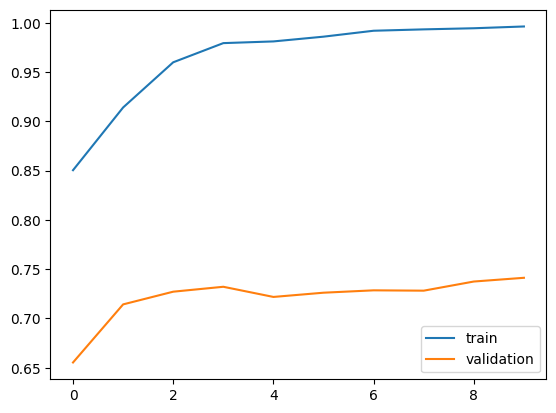

In [50]:
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

After some point we reach a plateau, and then we start over-fitting the train data:

CPU times: user 373 ms, sys: 3.01 ms, total: 376 ms
Wall time: 72.6 ms


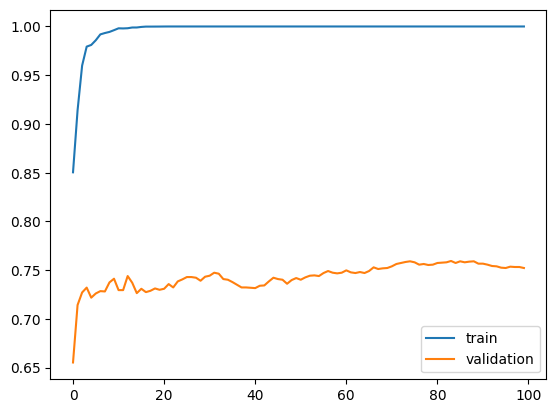

In [51]:
%%time
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    eta = 0.3 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(Xt, yt, 
              eval_set=[(Xt, yt),(Xv, yv)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

`eta` controls how fast we learn.

 * lower value: slower learning
 * higher value: faster learning, but potentially unstable

CPU times: user 617 ms, sys: 3.92 ms, total: 621 ms
Wall time: 123 ms


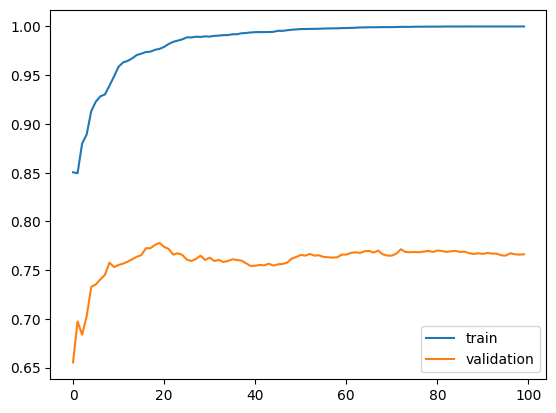

In [52]:
%%time
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.05 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

CPU times: user 411 ms, sys: 3.97 ms, total: 415 ms
Wall time: 79.6 ms


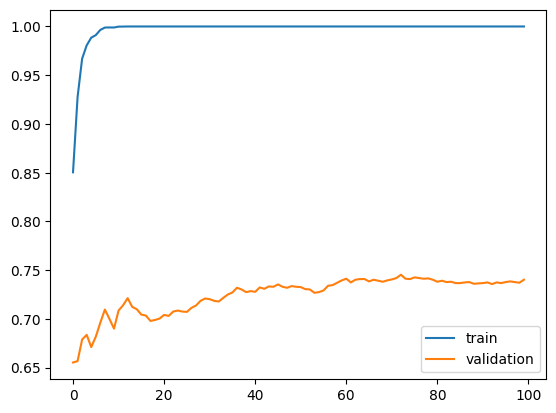

In [53]:
%%time
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.5 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

Then of course we may want to stop the iterations when we observe a decrease of the validation performance: that's **early stopping**.

In [54]:
## early stopping

clf = xgb.XGBClassifier(tree_method="hist", 
                        early_stopping_rounds=5 , 
                        eval_metric = "auc",
                        eta = 0.05 )
clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)])

clf.best_iteration , clf.best_score #  These are used by the predict() 

[0]	validation_0-auc:0.85041	validation_1-auc:0.65533
[1]	validation_0-auc:0.84945	validation_1-auc:0.69742
[2]	validation_0-auc:0.87995	validation_1-auc:0.68385
[3]	validation_0-auc:0.88927	validation_1-auc:0.70275
[4]	validation_0-auc:0.91314	validation_1-auc:0.73282
[5]	validation_0-auc:0.92285	validation_1-auc:0.73540
[6]	validation_0-auc:0.92835	validation_1-auc:0.74055
[7]	validation_0-auc:0.93021	validation_1-auc:0.74519
[8]	validation_0-auc:0.93927	validation_1-auc:0.75773
[9]	validation_0-auc:0.94871	validation_1-auc:0.75326
[10]	validation_0-auc:0.95864	validation_1-auc:0.75533
[11]	validation_0-auc:0.96315	validation_1-auc:0.75670
[12]	validation_0-auc:0.96471	validation_1-auc:0.75876
[13]	validation_0-auc:0.96729	validation_1-auc:0.76117
[14]	validation_0-auc:0.97074	validation_1-auc:0.76375
[15]	validation_0-auc:0.97208	validation_1-auc:0.76546
[16]	validation_0-auc:0.97383	validation_1-auc:0.77251
[17]	validation_0-auc:0.97419	validation_1-auc:0.77251
[18]	validation_0-au

(19, 0.7780068728522337)

We can use it here to evaluate the effect of `eta`:

CPU times: user 6.53 s, sys: 36.8 ms, total: 6.57 s
Wall time: 1.09 s


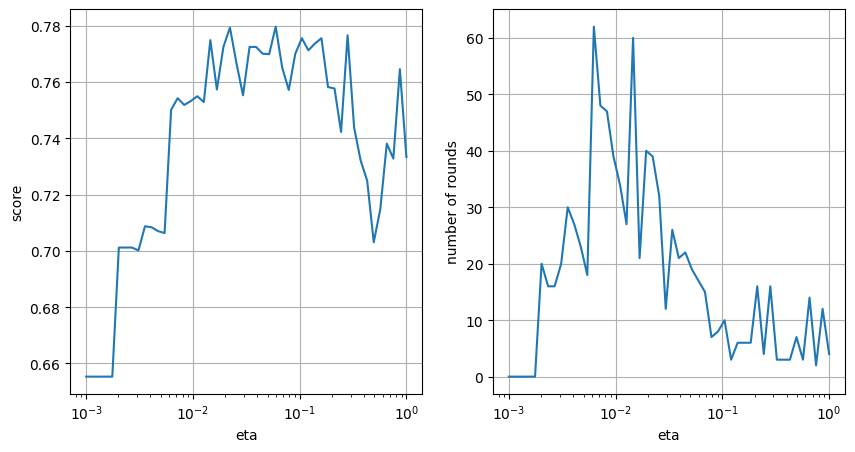

In [55]:
%%time
best_scores = []
num_rounds = []
etas = np.logspace(-3,0,50)
for eta in etas:
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2,
        early_stopping_rounds=10 ,
        eta = eta , n_estimators=500 , 
        eval_metric= 'auc' )

    xgb_model.fit(X_train , y_train  , 
                  eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  verbose=False )

    best_scores.append( xgb_model.best_score )
    num_rounds.append( xgb_model.best_iteration )

fig,ax=plt.subplots(1,2,figsize = (10,5))
ax[0].plot( etas , best_scores )
ax[0].set_xlabel('eta')
ax[0].set_ylabel('score')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot( etas , num_rounds )
ax[1].set_xlabel('eta')
ax[1].set_ylabel('number of rounds')
ax[1].set_xscale('log')
ax[1].grid()


You can tune all of them together with one simple GridSearchCV – what you’ve been doing so far (max_bin sweep, then depth/eta/n_estimators) is basically manual / coordinate search. A full grid just lets sklearn try all combinations of several hyperparameters at once.

The only catch: the grid must stay small, otherwise the number of combinations explodes.

One GridSearchCV over all params:

In [ ]:

ratio = len(yt[yt == 0]) / len(yt[yt == 1])

xgb_base = xgb.XGBClassifier(
    tree_method="hist",
    scale_pos_weight=ratio,
    eval_metric='auc',
    n_jobs=multiprocessing.cpu_count()-2,
    use_label_encoder=False  # if your xgboost complains
)

param_grid = {
    "max_depth": [3, 6],
    "n_estimators": [50, 100, 200],
    "eta": [0.01, 0.1],
    "max_bin": [32, 256],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
}

clf = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=1,      # keep 1 here because xgboost already uses threads
    verbose=1,
)

clf.fit(Xt, yt)

print("Best CV AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
best_model = clf.best_estimator_


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best CV AUC: 0.708654653798
Best params: {'colsample_bytree': 0.7, 'eta': 0.1, 'max_bin': 256, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/katwre/miniforge3/envs/intermediateML_2024/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:54:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [57]:
print("Best CV AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
best_model = clf.best_estimator_

Best CV AUC: 0.708654653798
Best params: {'colsample_bytree': 0.7, 'eta': 0.1, 'max_bin': 256, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
y_pred = best_model.predict(Xv)
y_proba = best_model.predict_proba(Xv)[:, 1]

print(confusion_matrix(yv, y_pred))
print(classification_report(yv, y_pred))
print("Val ROC AUC:", roc_auc_score(yv, y_proba))


[[91  6]
 [21  9]]
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87        97
         1.0       0.60      0.30      0.40        30

    accuracy                           0.79       127
   macro avg       0.71      0.62      0.64       127
weighted avg       0.76      0.79      0.76       127

Val ROC AUC: 0.7718213058419243


✔ Model detects non-responders well 94% recall, 87% F1 — excellent.

✔ Model assigns higher probability to true responders
ROC AUC 0.77 means:
→ If you randomly pick one responder and one non-responder, the model assigns higher score to the responder 77% of the time.

✔ Model struggles detecting responders (class imbalance!)
But that’s normal. Only ~20% of your data is class 1


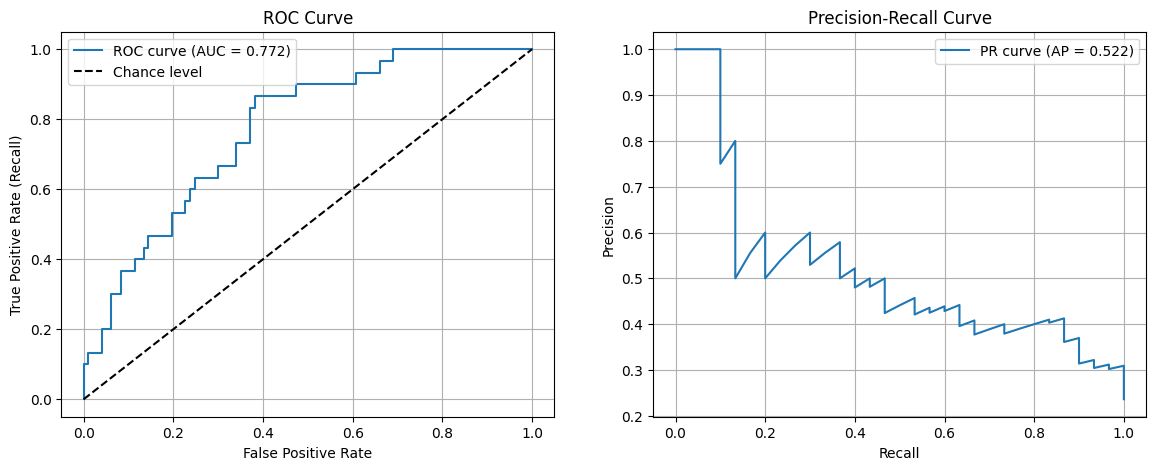

In [ ]:
# --- Compute ROC ---
fpr, tpr, roc_thresh = roc_curve(yv, y_proba)
roc_auc = auc(fpr, tpr)

# --- Compute Precision-Recall ---
precision, recall, pr_thresh = precision_recall_curve(yv, y_proba)
avg_precision = average_precision_score(yv, y_proba)

# --- Plot ROC + PR ---
plt.figure(figsize=(14, 5))

# --- ROC Curve ---
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# --- Precision Recall Curve ---
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR curve (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

plt.show()


1. ROC curve:

- The model can separate responders vs non-responders reasonably well.
- AUC 0.77 means:
    - If you pick a random responder and random non-responder, the model assigns a higher probability to the responder 77% of the time.
    - This is a clear improvement over earlier models you tried.

2. Precision–Recall Curve (AP = 0.522)

- This is even more impressive, because PR curve is very harsh when the positive class is small (only ~23% responders).
- Typical AP for imbalanced medical datasets often falls below 0.30.
- The AP = 0.522 suggests:
    - The model is genuinely picking up meaningful signal
    - You get reasonable precision (30–60%) across most recall levels
    - And you can adjust the threshold depending on what’s more important:
        - high precision (fewer false positives)
        - high recall (catch all responders)
